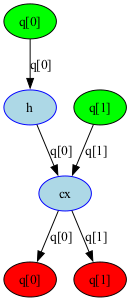

<Figure size 800x600 with 0 Axes>

In [1]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
import matplotlib.pyplot as plt
from qiskit.dagcircuit.dagnode import DAGOpNode, DAGInNode, DAGOutNode
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.dagcircuit import DAGOpNode
from qiskit.circuit.library import XGate, HGate, ZGate
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

import numpy as np

from optimizers import XHXtoHZReduction, HXHtoZReduction, RemoveConsecutiveH, MergeConsecutiveRX, TCountTemplateReduction, ToffoliTCountReduction, OptimizeConsecutiveSwaps, MergeAdjacentSwapsPass
from helpers import grover_oracle

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

dag = circuit_to_dag(qc)

fig = plt.figure(figsize=(8, 6))
dag.draw()

### Remove of consecutive H gates

Original circuit:


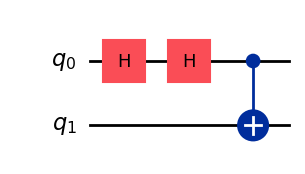

In [2]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(0) 
qc.cx(0, 1)

pass_manager = PassManager([RemoveConsecutiveH()])
optimized_circuit = pass_manager.run(qc)

print("Original circuit:")
qc.draw(output="mpl", style="iqp")



Optimized circuit:


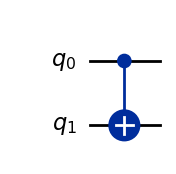

In [3]:
print("\nOptimized circuit:")
optimized_circuit.draw(output="mpl", style="iqp")

### Merge consecutive RX

Original circuit:


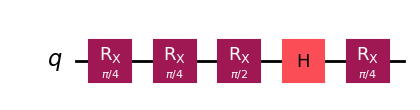

In [4]:
qc = QuantumCircuit(1)
qc.rx(np.pi/4, 0)
qc.rx(np.pi/4, 0)
qc.rx(np.pi/2, 0)
qc.h(0)
qc.rx(np.pi/4, 0)

print("Original circuit:")
qc.draw(output="mpl", style="iqp")



Optimized circuit:


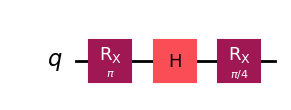

In [5]:
pass_manager = PassManager([MergeConsecutiveRX()])
optimized_circuit = pass_manager.run(qc)

print("\nOptimized circuit:")
optimized_circuit.draw(output="mpl", style="iqp")

### CX-T pattern

Original circuit:


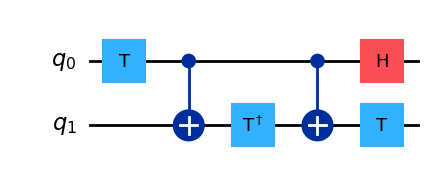

In [6]:
qc = QuantumCircuit(2)
qc.t(0)
qc.cx(0, 1)
qc.tdg(1)
qc.cx(0, 1)
qc.h(0)
qc.t(1)

print("Original circuit:")
qc.draw(output="mpl", style="iqp")


Optimized circuit:


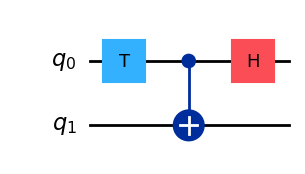

In [7]:
pass_manager = PassManager([TCountTemplateReduction()])
optimized_circuit = pass_manager.run(qc)

print("\nOptimized circuit:")
optimized_circuit.draw(output="mpl", style="iqp")


In [8]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.measure_all()

dag = circuit_to_dag(qc)

# Create and run the pass
pass_manager = PassManager([ToffoliTCountReduction()])
optimized_circuit = pass_manager.run(qc)

print("Original circuit:")
print(qc)
print("\nOptimized circuit:")
print(optimized_circuit)

Original circuit:
              ░ ┌─┐      
   q_0: ──■───░─┤M├──────
          │   ░ └╥┘┌─┐   
   q_1: ──■───░──╫─┤M├───
        ┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ┤ X ├─░──╫──╫─┤M├
        └───┘ ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 

Optimized circuit:
              ░ ┌─┐      
   q_0: ──■───░─┤M├──────
          │   ░ └╥┘┌─┐   
   q_1: ──■───░──╫─┤M├───
        ┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ┤ X ├─░──╫──╫─┤M├
        └───┘ ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2 


## Gate optimizations 

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap

cmap = CouplingMap([[0, 1], [1, 2]])

grover = QuantumCircuit(3, 3)
grover.h([0, 1, 2])
grover.cz(0, 2)  
grover.h([0, 1, 2])
grover.measure([0, 1, 2], [0, 1, 2])

print("Original Grover circuit:")
print(grover.draw())

grover_routed = transpile(grover, coupling_map=cmap, optimization_level=0)

print("\nGrover circuit routed for linear coupling map (with SWAPs):")
grover_routed.draw()

Original Grover circuit:
     ┌───┐   ┌───┐   ┌─┐   
q_0: ┤ H ├─■─┤ H ├───┤M├───
     ├───┤ │ ├───┤┌─┐└╥┘   
q_1: ┤ H ├─┼─┤ H ├┤M├─╫────
     ├───┤ │ ├───┤└╥┘ ║ ┌─┐
q_2: ┤ H ├─■─┤ H ├─╫──╫─┤M├
     └───┘   └───┘ ║  ║ └╥┘
c: 3/══════════════╩══╩══╩═
                   1  0  2 

Grover circuit routed for linear coupling map (with SWAPs):


┌───┐           ┌───┐┌─┐   
q_0 -> 0 ┤ H ├─────────■─┤ H ├┤M├───
         ├───┤┌───┐    │ ├───┤└╥┘┌─┐
q_1 -> 1 ┤ H ├┤ H ├─X──■─┤ H ├─╫─┤M├
         ├───┤└───┘ │ ┌─┐└───┘ ║ └╥┘
q_2 -> 2 ┤ H ├──────X─┤M├──────╫──╫─
         └───┘        └╥┘      ║  ║ 
    c: 3/══════════════╩═══════╩══╩═
                       1       0  2

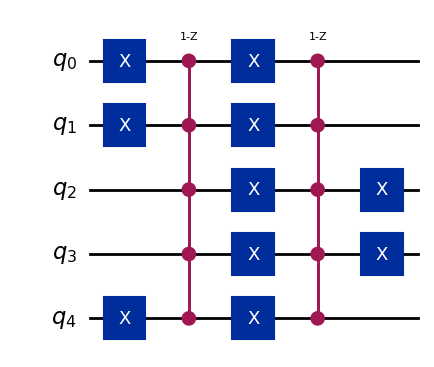

In [10]:
marked_states = ["01100", "10011"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

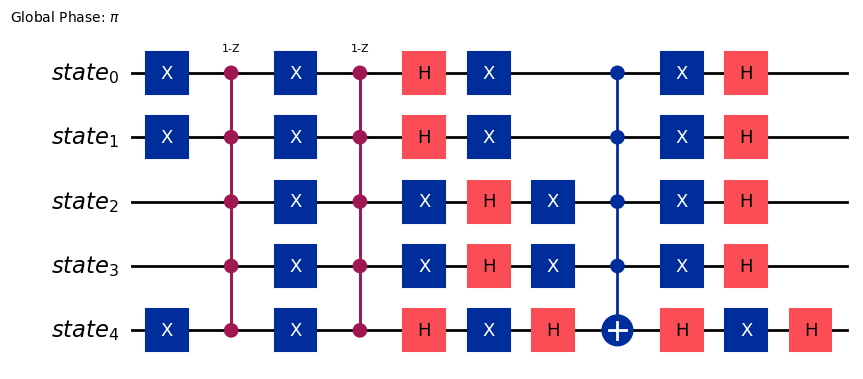

In [11]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

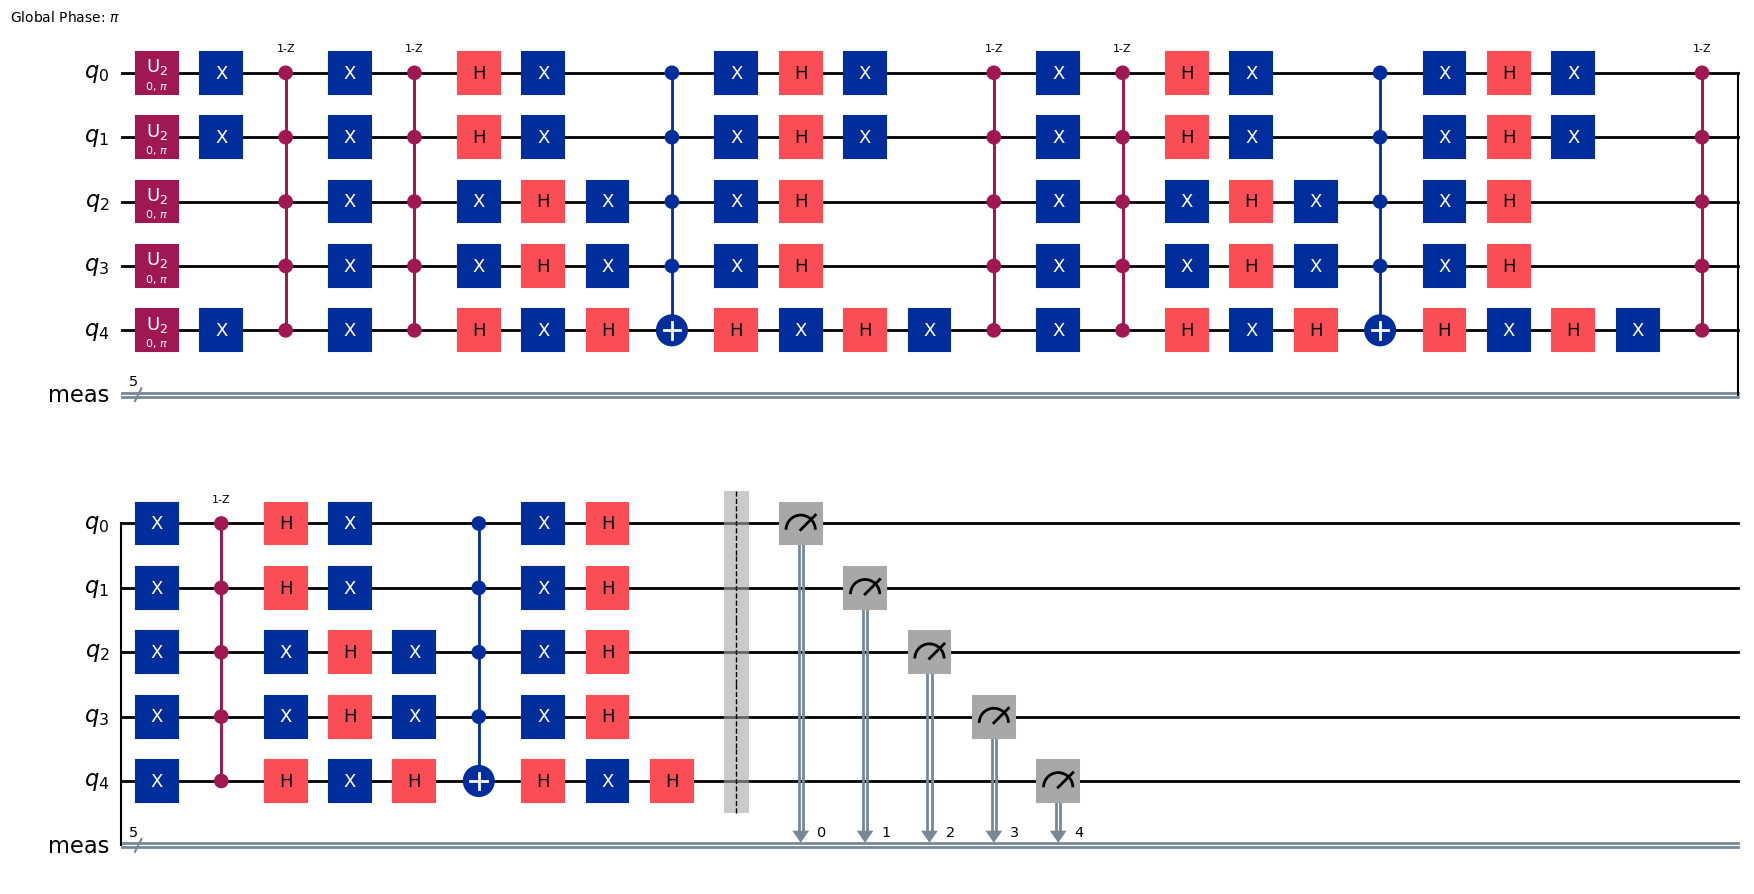

In [12]:
import math
grover_op = grover_op.decompose()
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")
qc.decompose().draw(output="mpl", style="iqp")

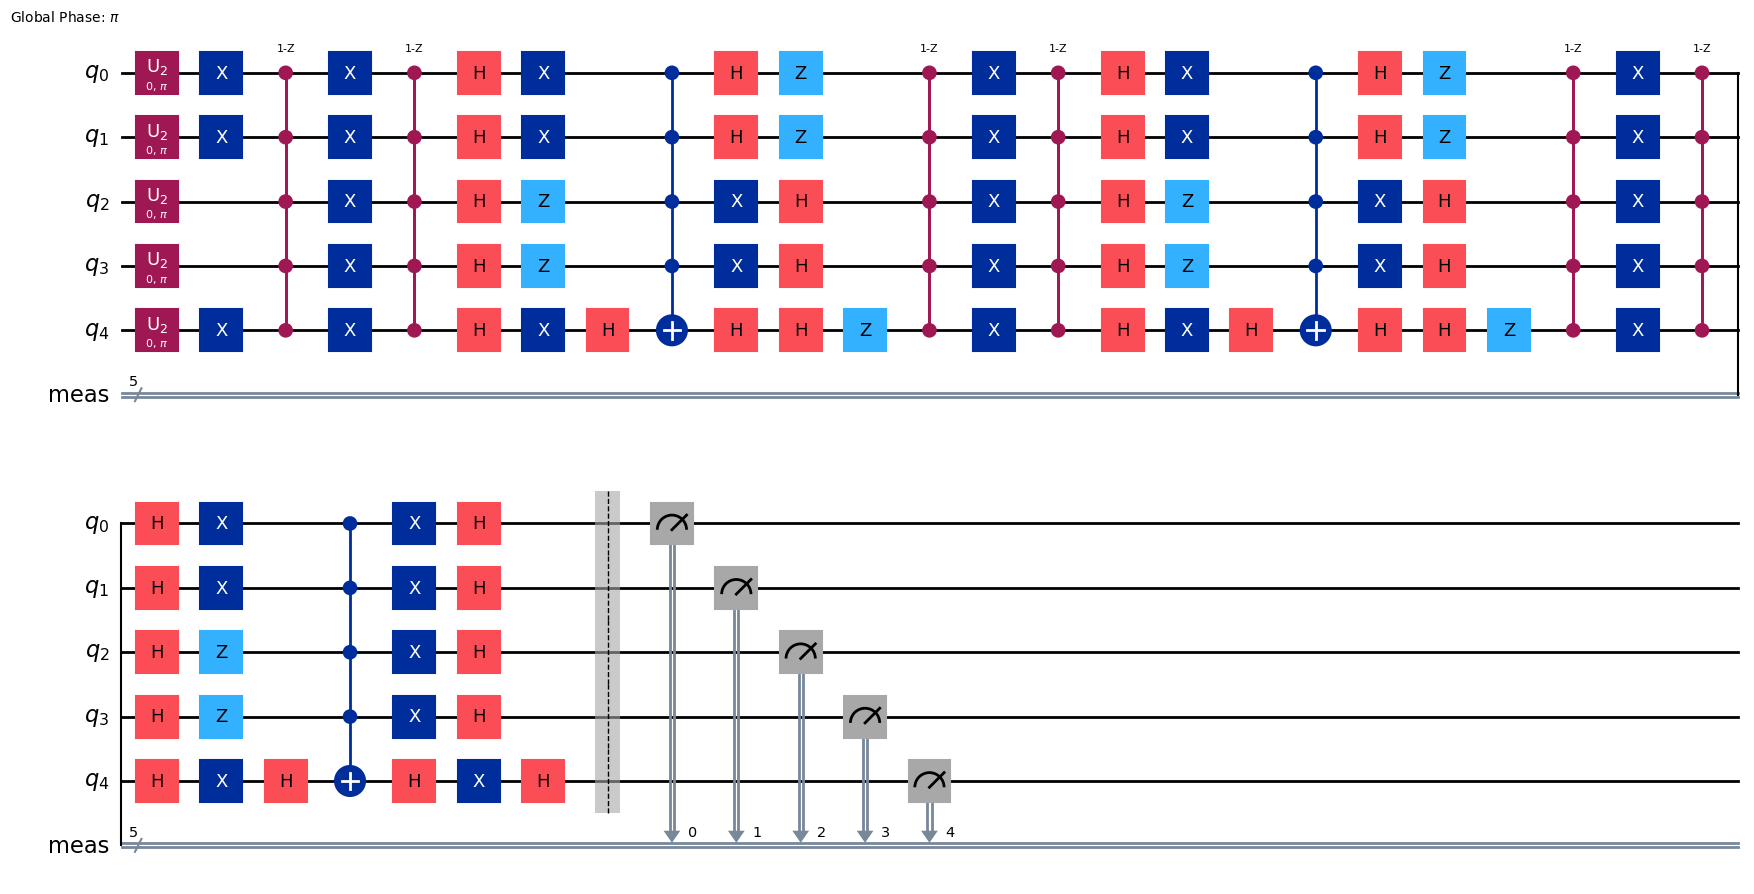

In [13]:
qc_decomposed = qc.decompose()
pass_manager = PassManager([XHXtoHZReduction()])
qc_decomposed = pass_manager.run(qc_decomposed)
qc_decomposed.draw(output="mpl", style="iqp")

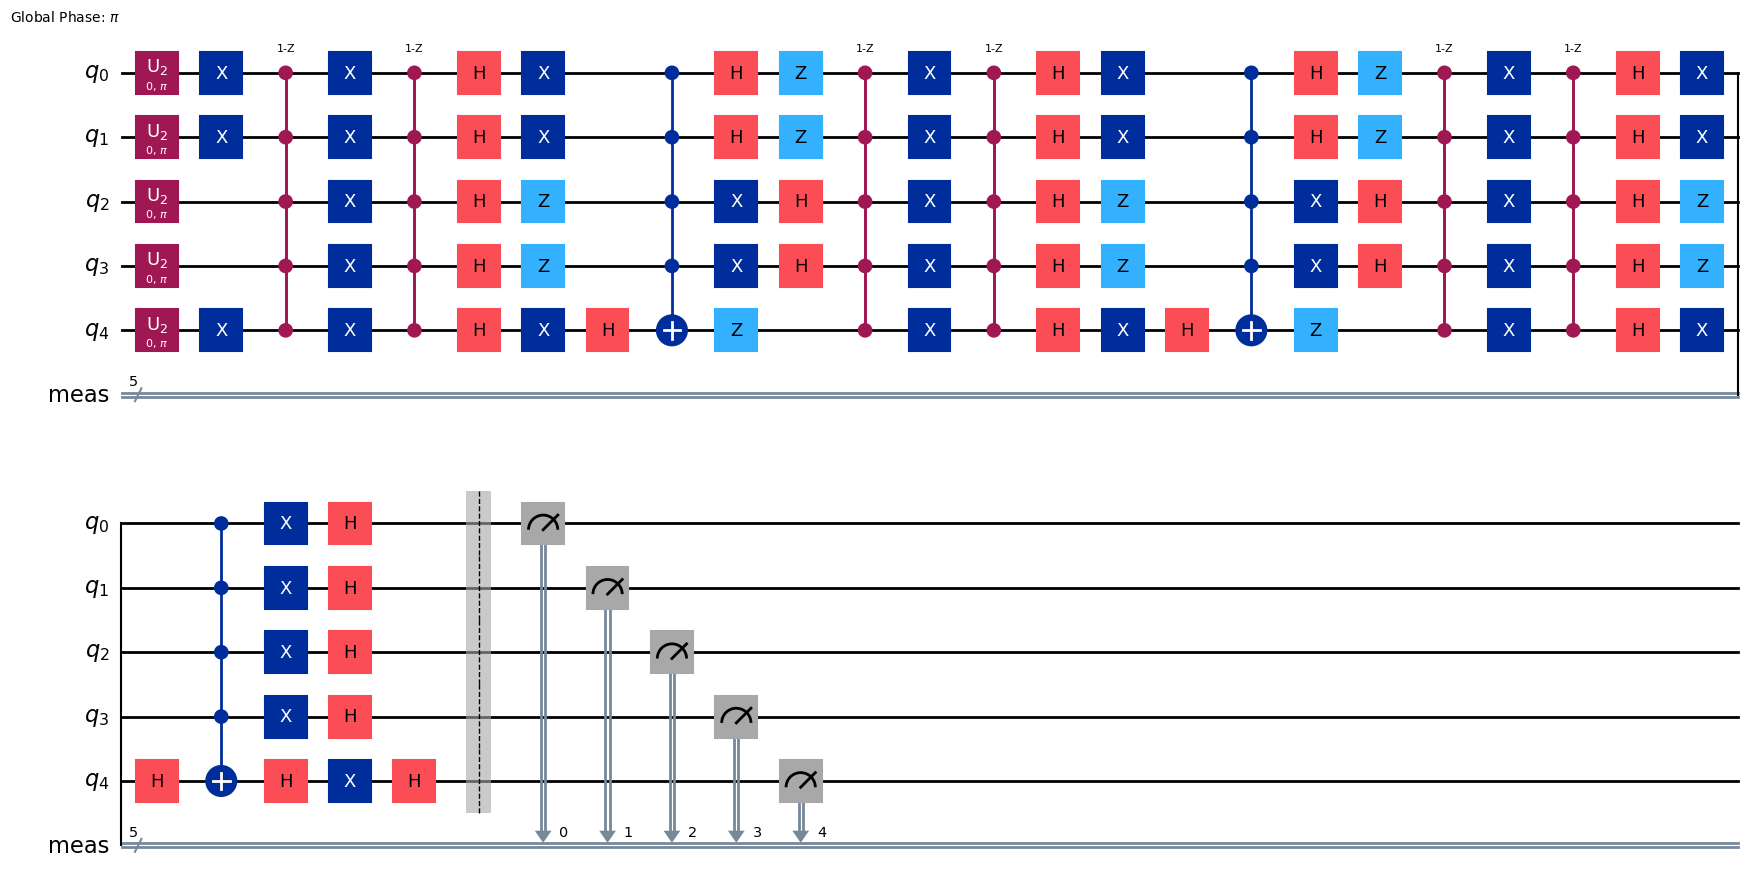

In [14]:
pass_manager = PassManager(RemoveConsecutiveH())
qc_decomposed = pass_manager.run(qc_decomposed)
qc_decomposed.draw(output="mpl", style="iqp")

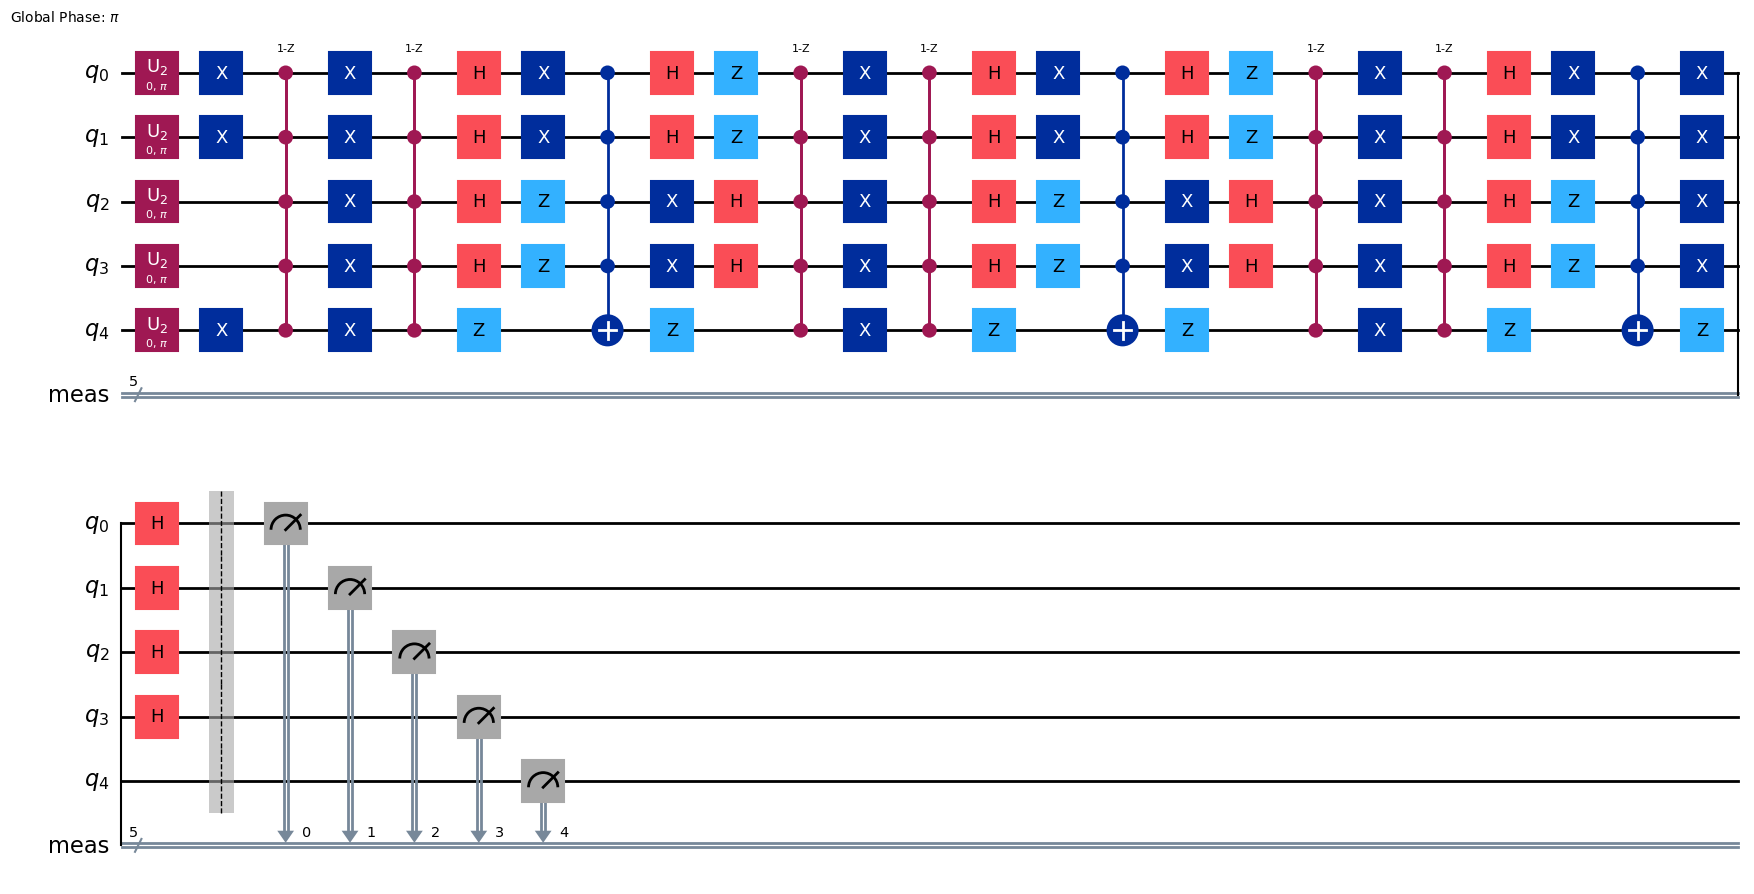

In [15]:
pass_manager = PassManager(HXHtoZReduction())
qc_decomposed = pass_manager.run(qc_decomposed)
qc_decomposed.draw(output="mpl", style="iqp")

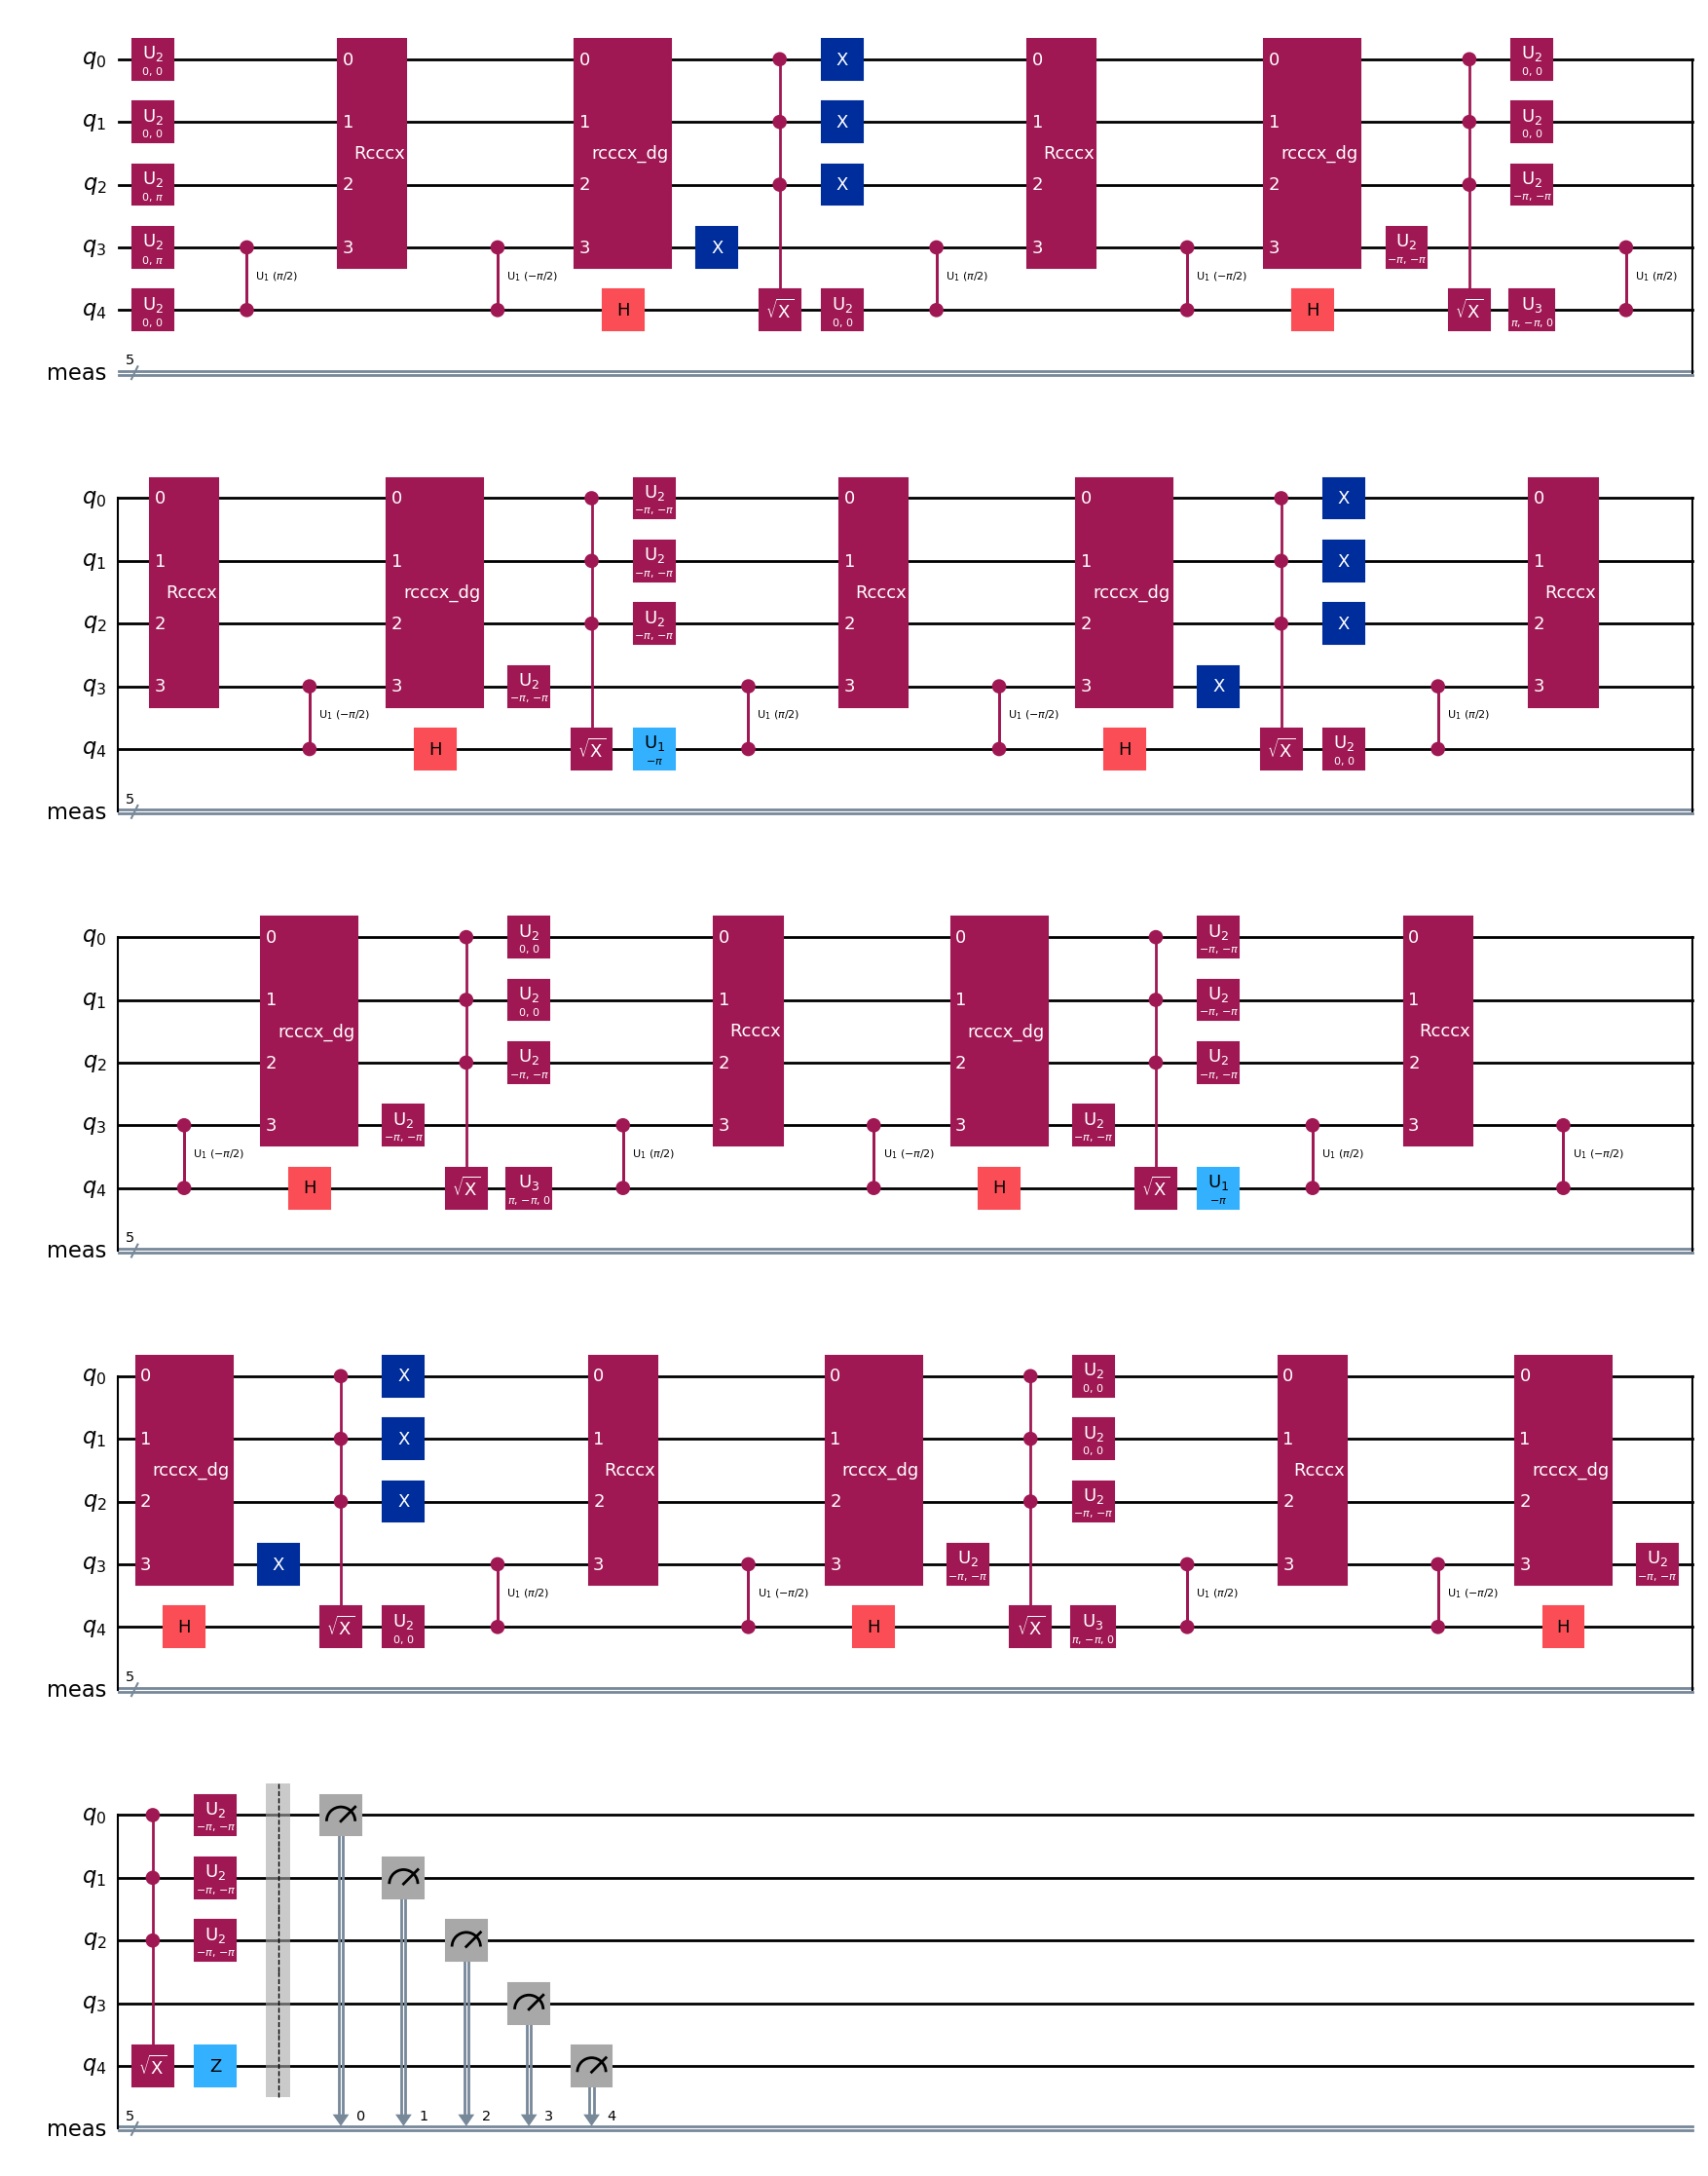

In [16]:
from qiskit.transpiler import CouplingMap

# Linear chain: 0-1-2-3-4
cmap = CouplingMap(couplinglist=[(0, 1), (1, 2), (2, 3), (3, 4)])
cmap.draw()

optimized_circuit = transpile(qc_decomposed, optimization_level=1)
optimized_circuit.draw(output="mpl", style="iqp")

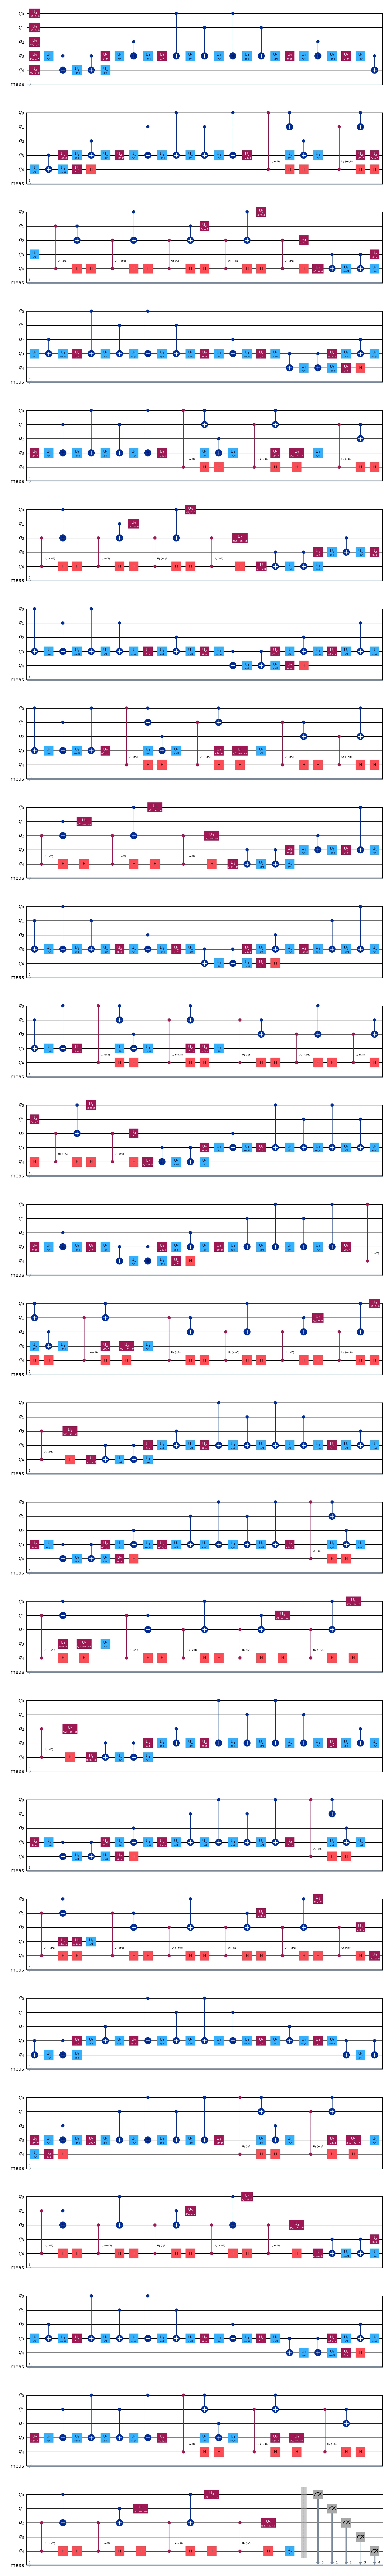

In [17]:
qc_final = optimized_circuit.decompose()

qc_final.draw(output="mpl", style="iqp")

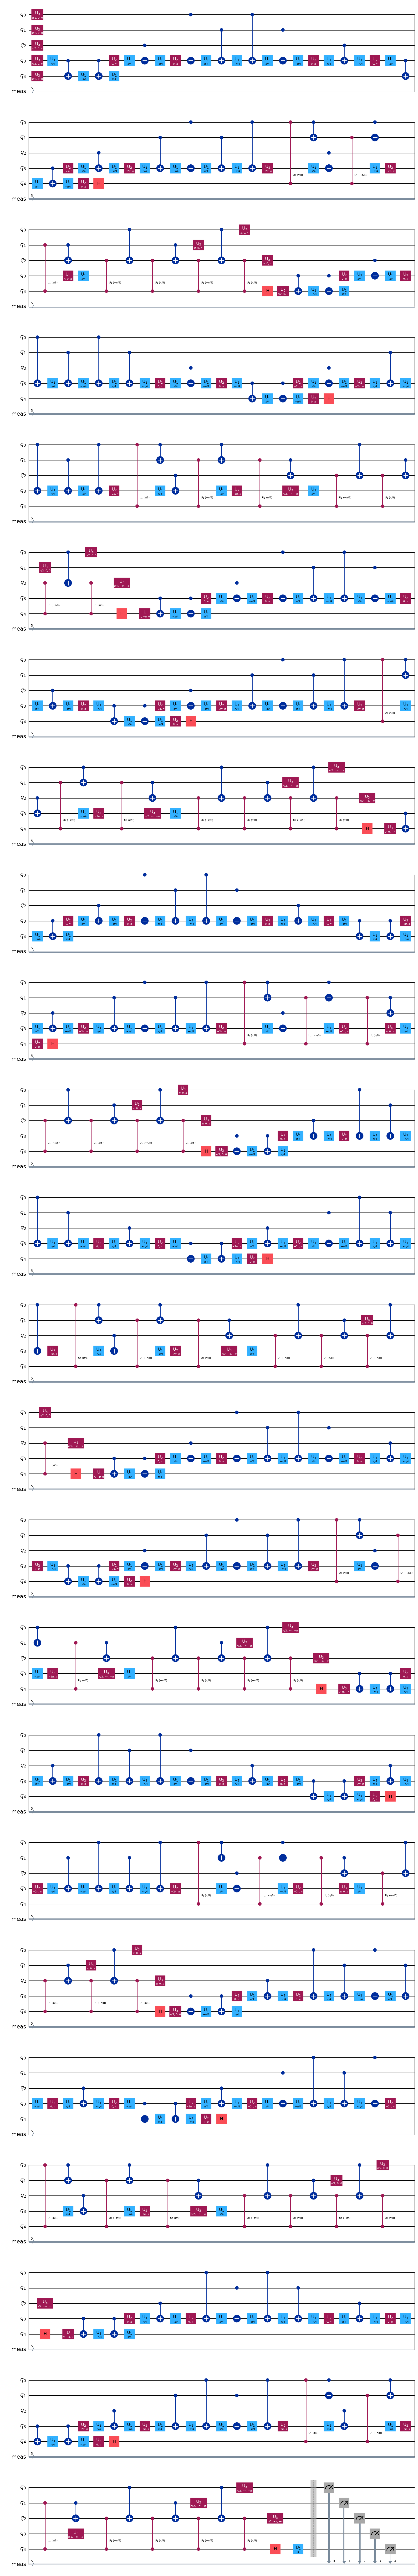

In [18]:
pass_manager = PassManager([XHXtoHZReduction(), RemoveConsecutiveH(), HXHtoZReduction(), MergeConsecutiveRX()])
optimized_circuit = pass_manager.run(qc_final)
optimized_circuit.draw(output="mpl", style="iqp")

In [19]:
print("Depth of original circuit: ", transpile(qc.decompose(), optimization_level=0).decompose().depth())
print("Depth after custom passes: ", transpile(qc_decomposed.decompose(), optimization_level=3).decompose().depth())
print("Depth after Qiskit's optimization (level 3): ", transpile(qc.decompose(), optimization_level=3).decompose().depth())
print("Depth after custom passes -> Qiskit's optimizations: ", qc_final.depth())
print("Depth after custom passes -> Qiskit's optimizations -> custom passes: ", optimized_circuit.depth())

Depth of original circuit:  569
Depth after custom passes:  534
Depth after Qiskit's optimization (level 3):  534
Depth after custom passes -> Qiskit's optimizations:  534
Depth after custom passes -> Qiskit's optimizations -> custom passes:  480


## Swap gate optimizations

Original circuit:


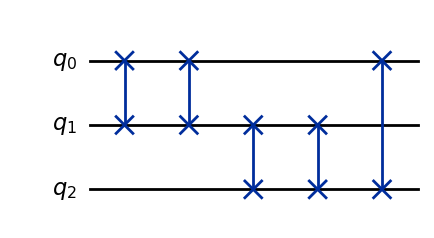

In [20]:
qc = QuantumCircuit(3)
qc.swap(0, 1)
qc.swap(0, 1)
qc.swap(1, 2)
qc.swap(1, 2)
qc.swap(0, 2) 

print("Original circuit:")
qc.draw(output="mpl", style="iqp")



Optimized circuit:


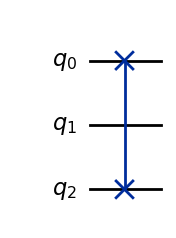

In [21]:
pm = PassManager()
pm.append(OptimizeConsecutiveSwaps())
optimized_qc = pm.run(qc)
print("\nOptimized circuit:")
optimized_qc.draw(output="mpl", style="iqp")

In [22]:
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager

# Create a circuit with adjacent swaps sharing a qubit
qc = QuantumCircuit(3)
qc.swap(0, 1)
qc.swap(1, 2)  # Adjacent swap sharing qubit 1
qc.swap(0, 2)  # This one stays

print("Original circuit:")
print(qc.draw())

pm = PassManager()
pm.append(MergeAdjacentSwapsPass())

optimized_qc = pm.run(qc)

print("\nOptimized circuit:")
print(optimized_qc.draw())

print("\nOperation counts before optimization:", qc.count_ops())
print("Operation counts after optimization:", optimized_qc.count_ops())


Original circuit:
              
q_0: ─X─────X─
      │     │ 
q_1: ─X──X──┼─
         │  │ 
q_2: ────X──X─
              

Optimized circuit:
        
q_0: ───
        
q_1: ─X─
      │ 
q_2: ─X─
        

Operation counts before optimization: OrderedDict([('swap', 3)])
Operation counts after optimization: OrderedDict([('swap', 1)])


Original circuit:


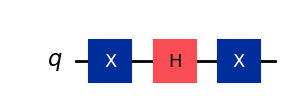

In [23]:
qc = QuantumCircuit(1)
qc.x(0)
qc.h(0)
qc.x(0)
print("Original circuit:")
qc.draw(output="mpl", style="iqp")



Transformed circuit:


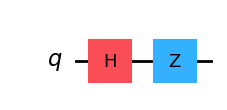

In [24]:
pm = PassManager([XHXtoHZReduction()])
new_qc = pm.run(qc)

print("\nTransformed circuit:")
new_qc.draw(output="mpl", style="iqp")

Original circuit:
   ┌───┐┌───┐┌───┐
q: ┤ H ├┤ X ├┤ H ├
   └───┘└───┘└───┘


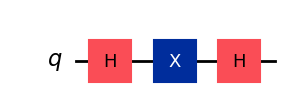

In [ ]:
class HXHtoZReduction(TransformationPass):
    def run(self, dag):
        for node in dag.topological_op_nodes():
            if isinstance(node.op, HGate):
                succ1 = [s for s in dag.successors(node) if isinstance(s, DAGOpNode)]
                if len(succ1) == 1 and isinstance(succ1[0].op, XGate):
                    h_node = succ1[0]
                    succ2 = [s for s in dag.successors(h_node) if isinstance(s, DAGOpNode)]
                    if len(succ2) == 1 and isinstance(succ2[0].op, HGate):
                        x2_node = succ2[0]
                        dag.substitute_node(node, ZGate(), inplace=True)
                        dag.remove_op_node(h_node)
                        dag.remove_op_node(x2_node)
        return dag

qc = QuantumCircuit(1)
qc.h(0)
qc.x(0)
qc.h(0)
print("Original circuit:")
qc.draw(output="mpl", style="iqp")



Transformed circuit:


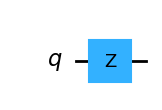

In [27]:
pm = PassManager([HXHtoZReduction()])
new_qc = pm.run(qc)

print("\nTransformed circuit:")
new_qc.draw(output="mpl", style="iqp")